# Descripción del conjunto de datos

Debe haber una columna de predicción por imagen, y las etiquetas se representan como números enteros que corresponden cada uno a una parte del cuerpo contenida en el conjunto de datos:

* Abdomen = 0
* Tobillo = 1
* Columna cervical = 2
* Tórax = 3
* Clavículas = 4
* Codo = 5
* Pies = 6
* Dedos = 7
* Antebrazo = 8
* Mano = 9
* Cadera = 10
* Rodilla = 11
* Pierna = 12
* Columna lumbar = 13
* Otros = 14
* Pelvis = 15
* Hombro = 16
* Senos paranasales = 17
* Cráneo = 18
* Muslo = 19
* Columna torácica = 20
* Muñeca = 21

*Nota*: Otros indica si la muestra contiene imágenes no radiográficas que a veces se colocan erróneamente en el sistema PACS como radiografías (por ejemplo, esofagograma, densitometría).

### Archivos

* train.csv - el conjunto de entrenamiento. Contiene el SOPInstanceUID y la información del objetivo.
* sample_submission.csv - un archivo de presentación de muestras en el formato correcto. Contiene SOPInstanceUID para el conjunto de test.

### Columnas

* SOPInstanceUID- Cada SOPInstanceUID corresponde a una imagen única.
* Target - La etiqueta asignada a cada muestra.

# SetUp

In [1]:
!pip install pydicom
!pip install pillow
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
import shutil
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import warnings
import random
from zipfile import ZipFile
import re
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback

warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

In [4]:
# Rutas a los directorios
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head(10)


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601496804394945741428,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704967879802673908605,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949928855045724356601,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892701383895533277303,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269035908958425925148,9
5,1.2.826.0.1.3680043.8.498.80404681981834387091293069933458998586,0
6,1.2.826.0.1.3680043.8.498.16743022096024694044879854041924202666,2
7,1.2.826.0.1.3680043.8.498.33303514480609398517548566741205534465,2
8,1.2.826.0.1.3680043.8.498.15144815417970827102709069064050334659,13
9,1.2.826.0.1.3680043.8.498.19878644487806502082817203359923592427,3


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1278 non-null   object
 1   Target          1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


# Procesamiento de imagenes

Ajuste de dimensiones y parametros. Aca se pueden agregar otras transformaciones y filtros para mejorar las siluetas. Tambien aplicar transformaciones que vimos en clase para reducir la dimensionalidad. Revisar

In [40]:
#Numero maximo de imagenes para entrenar el modelo
max = len(train_df)

In [41]:

def preprocess_image(dicom):
    """
    Preprocess a DICOM image and return a numpy array.
    """
    img = dicom.pixel_array
    # Clip the image intensities to the 1st and 99th percentiles
    p01 = np.percentile(img.ravel(), 1)
    p99 = np.percentile(img.ravel(), 99)
    img[img > p99] = p99
    img[img < p01] = p01
    # Invert the image if it is MONOCHROME1
    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        img = np.invert(img)
    # Normalize the image to the range 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = cv2.convertScaleAbs(img)
    return img

def convert_to_rgb(img):
    """
    Convert a single-channel or two-channel image to RGB.
    """
    if len(img.shape) == 2:  # Grayscale
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[-1] == 2:  # Two channels
        img = np.concatenate([img, img[:, :, :1]], axis=-1)  # Duplicate one channel
    return img



def preprocess_and_load_image(file_path, target_size=(224, 224)):
    """
    Combined function to preprocess and load a DICOM image, then resize it to the target size.
    """
    dicom = pydicom.dcmread(file_path)
    img = preprocess_image(dicom)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img = convert_to_rgb(img)
    return img




Procesamiento batch de todas las imagenes y division en test y train

Cargar, procesar y guardar imagenes en zip

In [8]:
"""
def preprocess_images(num_images, train_df, train_dir):
    X = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Cargar y preprocesar las imágenes de entrenamiento especificadas
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Preprocesando imágenes"):
        if idx >= num_images:
            break
        img_path = os.path.join(train_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_and_load_image(img_path)  # Utiliza tu función de preprocesamiento de imágenes aquí)
        X.append(img)


    X = np.array(X)
    return X


def save_images_to_zip(X, zip_path):
    with ZipFile(zip_path, 'w') as zipf:
        for idx, img in tqdm(enumerate(X), total=len(X), desc="Guardando imágenes"):
            img_filename = f'image_{idx}.png'

            # Convertir la imagen a formato adecuado para guardar con PIL
            pil_img = Image.fromarray(img)

            with BytesIO() as buffer:
                pil_img.save(buffer, format="PNG", quality=100)  # Guardar con la máxima calidad en PNG
                buffer.seek(0)
                zipf.writestr(img_filename, buffer.read())


# Especificar la cantidad de imágenes a procesar
num_images_to_process = max

# Preprocesar las imágenes
X = preprocess_images(num_images_to_process, train_df, train_dir)

# Especificar el directorio de guardado y el nombre del archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_6.zip'

# Guardar las imágenes procesadas en un archivo zip
save_images_to_zip(X, zip_path)

"""

'\ndef preprocess_images(num_images, train_df, train_dir):\n    X = []\n\n    # Obtener la cantidad total de imágenes\n    total_images = min(num_images, len(train_df))\n\n    # Cargar y preprocesar las imágenes de entrenamiento especificadas\n    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Preprocesando imágenes"):\n        if idx >= num_images:\n            break\n        img_path = os.path.join(train_dir, row[\'SOPInstanceUID\'] + \'.dcm\')\n        img = preprocess_and_load_image(img_path)  # Utiliza tu función de preprocesamiento de imágenes aquí)\n        X.append(img)\n\n\n    X = np.array(X)\n    return X\n\n\ndef save_images_to_zip(X, zip_path):\n    with ZipFile(zip_path, \'w\') as zipf:\n        for idx, img in tqdm(enumerate(X), total=len(X), desc="Guardando imágenes"):\n            img_filename = f\'image_{idx}.png\'\n\n            # Convertir la imagen a formato adecuado para guardar con PIL\n            pil_img = Image.fromarray(img)\n\n          

Extraer imagenes

In [42]:
def extract_and_load_images(zip_path):
    # Crear un directorio temporal para extraer las imágenes
    extract_dir = './temp_extracted_images'
    os.makedirs(extract_dir, exist_ok=True)

    # Extraer los archivos del zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Obtener la lista de archivos extraídos y ordenarlos alfabéticamente
    extracted_files = os.listdir(extract_dir)
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Ordenar los archivos según el número en el nombre

    # Lista para almacenar las imágenes cargadas
    X = []

    # Cargar las imágenes seleccionadas
    for filename in extracted_files:
        img_path = os.path.join(extract_dir, filename)
        img = plt.imread(img_path)
        X.append(img)

    # Convertir la lista de imágenes a un array de numpy
    X = np.array(X)

    # Limpiar el directorio temporal
    for file in extracted_files:
        os.remove(os.path.join(extract_dir, file))
    os.rmdir(extract_dir)

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    print(f"Total de imágenes descomprimidas: {len(extracted_files)}")

    return X

# Especificar la ruta del archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5.zip'

# Extraer y cargar las imágenes en la variable X
X = extract_and_load_images(zip_path)


Proceso de extracción y carga de imágenes completado correctamente.
Total de imágenes descomprimidas: 1278


encode labels y split

In [43]:
def encode_labels(train_df, num_images):
    y = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Obtener las etiquetas de las imágenes
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Codificando etiquetas"):
        if idx >= num_images:
            break
        y.append(row['Target'])

    return y

def encode_labels_2(train_df, num_images):
    y = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Obtener las etiquetas de las imágenes
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Codificando etiquetas"):
        if idx >= num_images:
            break
        y.append(row['Target'])

    # Convertir las listas de etiquetas en matrices numpy
    y = np.array(y)

    # Codificación de las etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return y_encoded, le

def split_train_val_sets(X, y, test_size=0.2, random_state=42):
    # Dividir en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

# Especificar la cantidad de imágenes a procesar y el tamaño de imagen deseado
num_images_to_process = max # Usar todas las imágenes disponibles

# Codificar las etiquetas
y, le = encode_labels_2(train_df, num_images_to_process)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = split_train_val_sets(X, y)




Codificando etiquetas: 100%|██████████| 1278/1278 [00:00<00:00, 22294.72it/s]


Visualizacion de imagenes extraidas y targets

In [44]:
import matplotlib.pyplot as plt

# Determinar el número máximo de imágenes a mostrar
num_images_to_show = min(25, len(X_train))

# Determinar el número de filas y columnas para la cuadrícula
num_rows = min(5, (num_images_to_show + 4) // 5)  # Asegura al menos una fila
num_cols = min(5, num_images_to_show)  # Asegura al menos una columna

# Configurar la cuadrícula para la visualización
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

# Iterar sobre las imágenes a mostrar
for i in range(num_images_to_show):
    row = i // num_cols
    col = i % num_cols

    # Obtener la imagen y la etiqueta correspondiente
    img = X_train[i]
    label = y_train[i]

    # Mostrar la imagen
    if num_rows == 1:  # Si solo hay una fila, axs será un arreglo unidimensional
        axs[col].imshow(img)
        axs[col].axis('off')
        axs[col].set_title(f'Image {i + 1}\nLabel: {label}')
    else:  # Si hay más de una fila, axs será una matriz bidimensional
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Image {i + 1}\nLabel: {label}')

# Ocultar los ejes de los subplots no utilizados
for j in range(num_images_to_show, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    if num_rows == 1:  # Si solo hay una fila, axs será un arreglo unidimensional
        axs[col].axis('off')
    else:  # Si hay más de una fila, axs será una matriz bidimensional
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Modelo

### Implementacion con Fast AI

ResNet, que significa "Redes Residuales", es una arquitectura de red neuronal convolucional (CNN) desarrollada por Microsoft Research en 2015. ResNet introdujo el concepto de "skip connections" o "conexiones residuales", que permiten que las redes neuronales profundas se vuelvan aún más profundas sin sufrir el problema de degradación de la precisión.


'Un "epoch" en el contexto del entrenamiento de modelos de aprendizaje automático se refiere a una pasada completa de todos los ejemplos de entrenamiento a través del modelo. En otras palabras, durante un epoch, el modelo ve todos los ejemplos de entrenamiento una vez y ajusta sus pesos en consecuencia para mejorar su desempeño.

Durante el entrenamiento de un modelo, los datos de entrenamiento se dividen en lotes de un tamaño específico (por ejemplo, 32, 64, etc.). Durante cada epoch, el modelo pasa por todos los lotes de entrenamiento, calcula la pérdida y ajusta sus pesos utilizando un algoritmo de optimización, como el descenso del gradiente estocástico (SGD) o Adam. Después de pasar por todos los lotes de entrenamiento, se completa un epoch y el modelo pasa al siguiente epoch.

El número de epochs que se especifica en el entrenamiento del modelo (epochs=10 en tu caso) indica cuántas veces se repetirá este proceso completo de pasar por todos los ejemplos de entrenamiento. A menudo, se requieren múltiples epochs para que el modelo aprenda patrones complejos en los datos y mejore su rendimiento. Sin embargo, es importante evitar el sobreajuste al entrenar demasiado tiempo, por lo que es común utilizar técnicas como el early stopping para detener el entrenamiento una vez que el rendimiento en el conjunto de validación deja de mejorar.'

Extracion de imagenes te train en zip, y preprocesaado con data augmentation

Proceso de extracción y carga de imágenes completado correctamente.
Total de imágenes descomprimidas: 1278


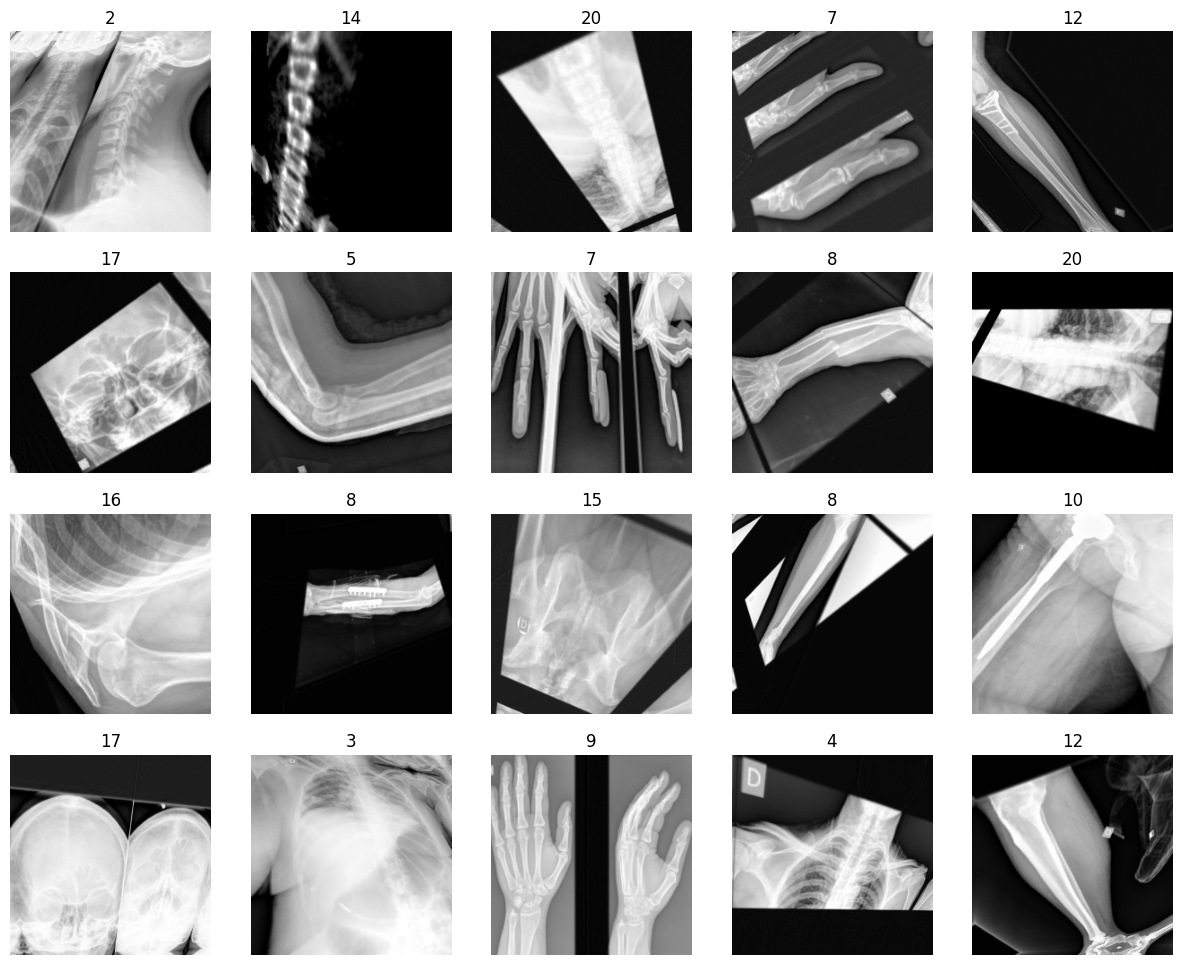

In [57]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
from imblearn.over_sampling import RandomOverSampler
from pathlib import Path

# Funciones globales para obtener imágenes y etiquetas
def get_x(x):
    return PILImage.create(x['image'])

def get_y(x):
    return x['label']

def extract_and_load_images(zip_path):
    extract_dir = Path('./temp_extracted_images')
    extract_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    extracted_files = list(extract_dir.glob('*'))
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x.name).group()))

    X = [plt.imread(file) * 255 for file in extracted_files]
    X = np.stack(X).astype(np.uint8)

    # Limpiar el directorio temporal
    for file in extracted_files:
        file.unlink()
    extract_dir.rmdir()

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    print(f"Total de imágenes descomprimidas: {len(X)}")

    return X

def create_dataloaders(X, y, sample_size=1):
    if sample_size < 1:
        sample_indices = np.random.choice(len(X), int(len(X) * sample_size), replace=False)
        X, y = X[sample_indices], y[sample_indices]

    ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
    indices = np.arange(len(y)).reshape(-1, 1)
    resampled_indices, y_resampled = ros.fit_resample(indices, y)

    data = [{'image': X[i], 'label': y_resampled[i]} for i in resampled_indices.flatten()]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        getters=[get_x, get_y],
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(224),
        batch_tfms=aug_transforms(mult=2, do_flip=True, flip_vert=True, max_rotate=20, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)
    )

    return dblock.dataloaders(data, bs=32)



# Extraer y cargar las imágenes en la variable X
X = extract_and_load_images(Path('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5.zip'))

# Crear los DataLoaders
dls = create_dataloaders(X, y)

# Visualizar algunas imágenes aumentadas junto con sus etiquetas
dls.show_batch(max_n=20)



### Entrenamiento Modelo (Best Version 0,93292)

Implementacion de balanceo de clases y pre procesamiento de imagenes

Construccion de modelo con Densenet, pre entrenamiento con Lr alto, y fine tunning de capas superiores con lr bajo

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,0.545542,0.156220,0.958382,01:44
1,0.213598,0.047824,0.986651,01:46
2,0.114934,0.021450,0.993325,01:46


epoch,train_loss,valid_loss,accuracy,time
0,0.097441,0.027688,0.989007,02:14
1,0.181157,0.070072,0.978406,02:16
2,0.142740,0.034253,0.989007,02:15
3,0.086567,0.016760,0.994503,02:14
4,0.081381,0.020954,0.994896,02:16
5,0.050347,0.009372,0.996859,02:15
6,0.039365,0.013807,0.997644,02:14
7,0.014223,0.003708,0.998822,02:15
8,0.009989,0.001489,0.999607,02:14
9,0.014243,0.001463,0.999607,02:14


Precisión General: 0.9996073842048645
Pérdida: 0.0014625152107328176


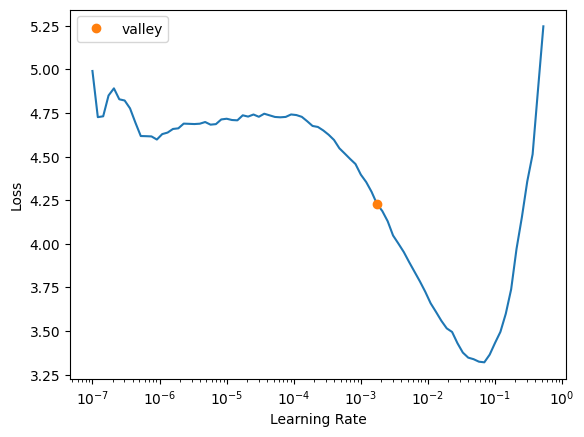

In [58]:
# Construir el modelo con DenseNet
learn = vision_learner(dls, densenet121, metrics=accuracy)

# Encontrar el learning rate óptimo con el LR Finder
lr_finder = learn.lr_find()

# Obtener el learning rate sugerido
lr_suggested = lr_finder.valley

# Implementar early stopping
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

# Ajuste inicial del modelo con un ciclo de entrenamiento de 3 épocas usando el learning rate sugerido
learn.fit_one_cycle(3, lr_max=lr_suggested)

# Descongelar las últimas tres capas
learn.unfreeze()
learn.freeze_to(-3)

# Ajuste fino del modelo utilizando un learning rate más bajo para las capas recién descongeladas
learn.fit_one_cycle(10, lr_max=slice(lr_suggested/100, lr_suggested), cbs=[early_stopping_cb])

# Obtener la precisión general y la pérdida
accuracy = learn.validate()[1]
loss = learn.validate()[0]

# Imprimir la precisión general y la pérdida
print(f'Precisión General: {accuracy}')
print(f'Pérdida: {loss}')




In [62]:
# Guardar el modelo entrenado
save_model_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/models/'
learn.export(os.path.join(save_model_path, 'best_model_densenet_.pkl'))

### Visualizacion de Imagenes y targets ENTRENAMIENTO

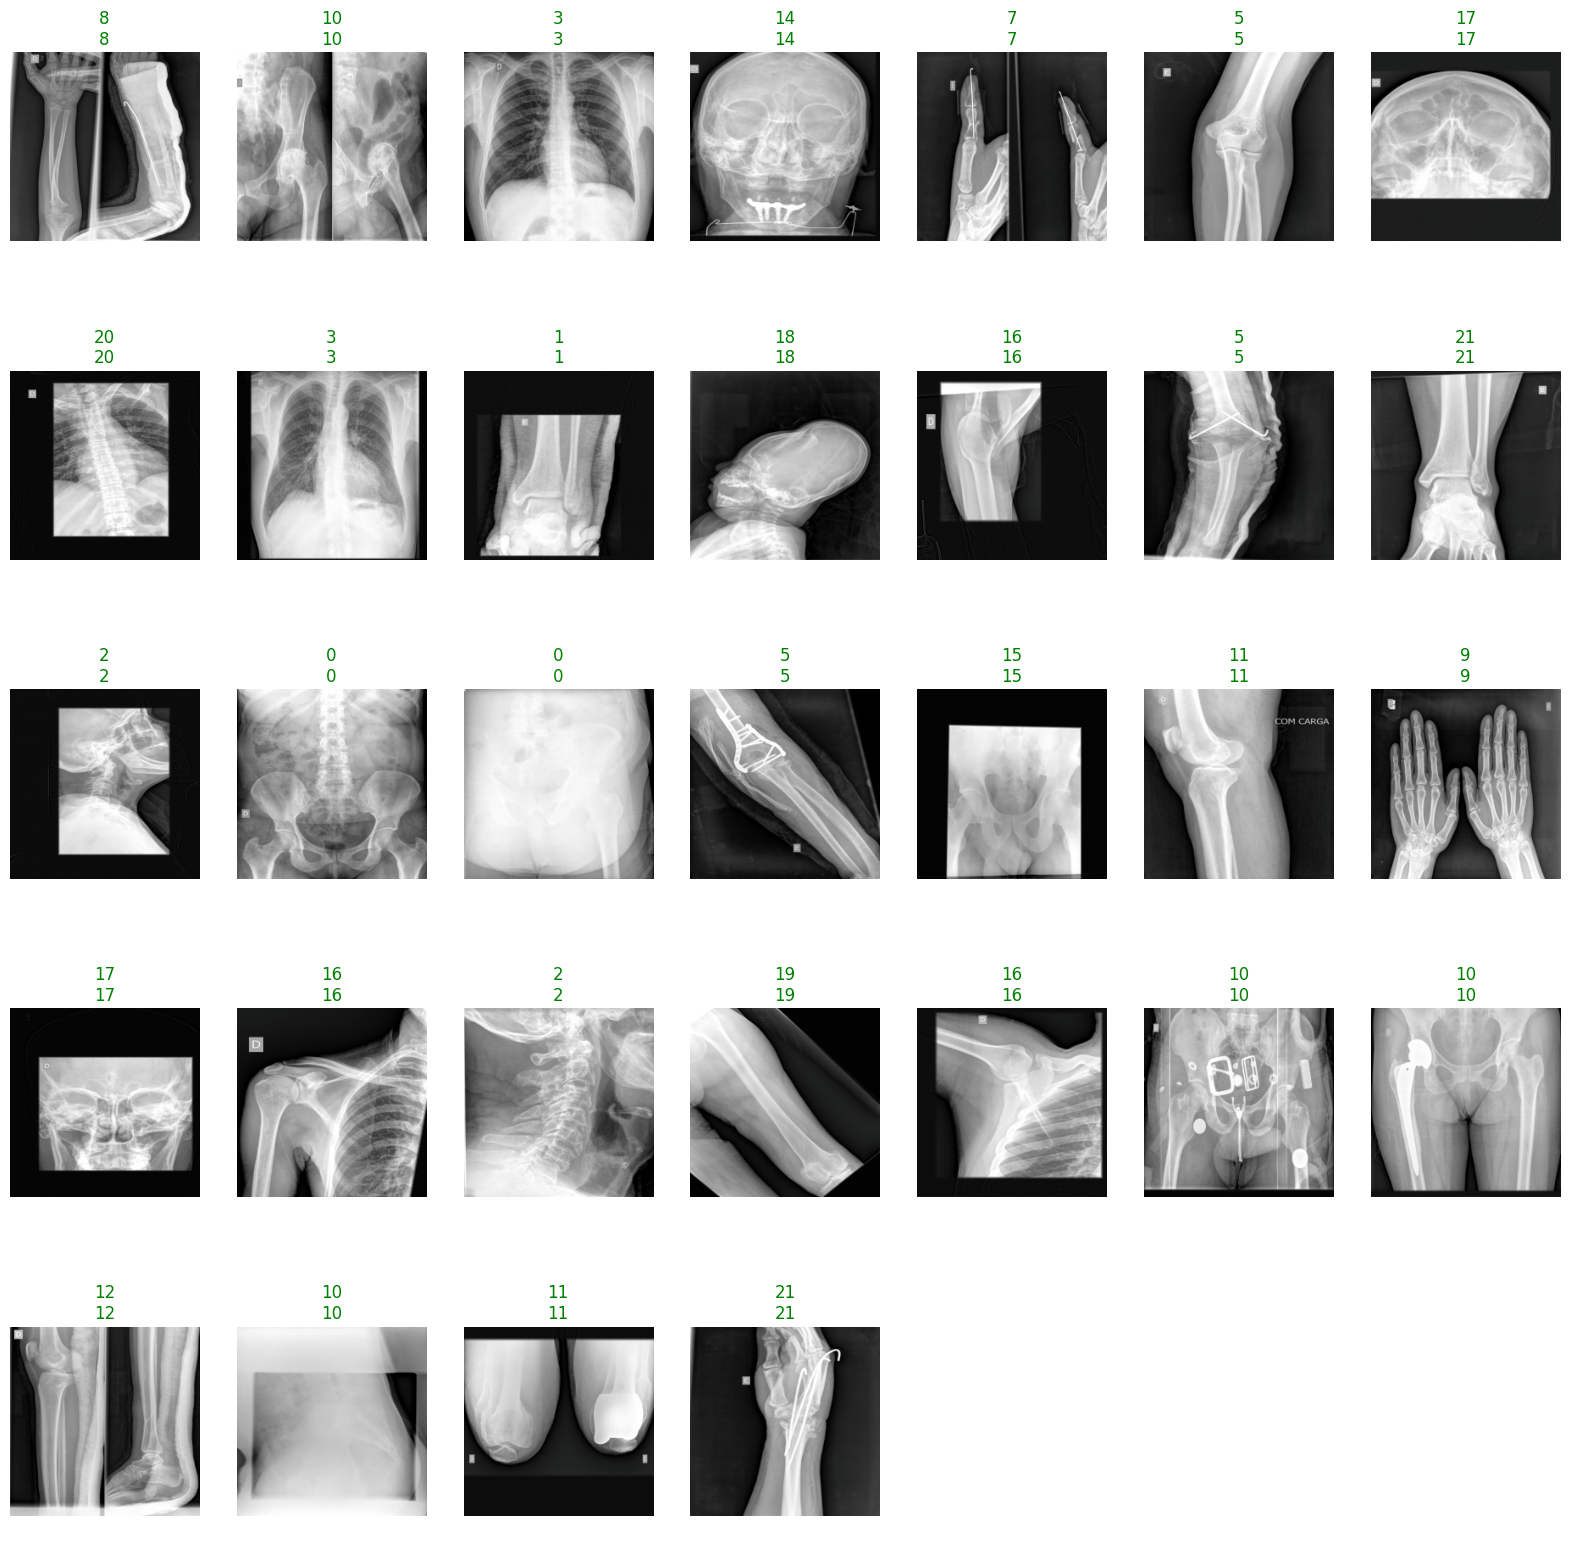

In [60]:
from fastai.vision.all import load_learner

# Mostrar los resultados utilizando el modelo cargado
learn.show_results(max_n=100, figsize=(20, 20))

### Analisis de imagenes del sample_sumission y aplicacion de predicciones

Procesamiento de imagenes de test

In [ ]:
"""
import re

def preprocess_and_save_test_images(test_df, test_dir, zip_path, target_size=(224, 224)):
    X_test = []

    # Crear una barra de progreso acumulativo
    pbar = tqdm(total=len(test_df), desc="Procesando imágenes de test")

    for idx, row in test_df.iterrows():
        img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_and_load_image(img_path, target_size=target_size)
        X_test.append(img)
        pbar.update(1)

    pbar.close()

    save_images_to_zip(X_test, zip_path)
    print("Proceso de guardado de imágenes completado correctamente.")

def save_images_to_zip(X, zip_path):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for idx, img in tqdm(enumerate(X), total=len(X), desc="Guardando imágenes"):
            img_filename = f'image_{idx}.png'

            # Convertir la imagen a formato adecuado para guardar con PIL
            if img.shape[2] == 3:  # RGB
                pil_img = Image.fromarray(img, mode='RGB')
            elif img.shape[2] == 1:  # Grayscale
                pil_img = Image.fromarray(img[:, :, 0], mode='L')  # 'L' mode is for (8-bit pixels, black and white)

            with BytesIO() as buffer:
                pil_img.save(buffer, format="PNG")
                buffer.seek(0)
                zipf.writestr(img_filename, buffer.read())


# Especificar la cantidad de imágenes a procesar y el tamaño de imagen deseado
num_images_to_process = len(train_df)  # Puedes ajustar esto según tus necesidades
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_test_5.zip'

# Cargar el DataFrame de test
test_df_1 = pd.read_csv(sample_submission_csv)
test_df = test_df_1.head(len(test_df_1))

# Procesar y guardar las imágenes de test en un archivo zip
preprocess_and_save_test_images(test_df, test_dir, zip_path, target_size=(224, 224))

"""

Descomprimir imagenes y aplicar predicciones

In [ ]:
def extract_and_load_images(zip_path, img_size=(224, 224)):
    # Crear un directorio temporal para extraer las imágenes
    extract_dir = './temp_extracted_images'
    os.makedirs(extract_dir, exist_ok=True)

    # Extraer los archivos del zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Obtener la lista de archivos extraídos y ordenarlos alfabéticamente
    extracted_files = os.listdir(extract_dir)
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Ordenar los archivos según el número en el nombre

    # Lista para almacenar las imágenes cargadas
    X = []

    # Cargar las imágenes seleccionadas
    for filename in extracted_files:
        img_path = os.path.join(extract_dir, filename)
        img = PILImage.create(img_path)
        img = img.resize(img_size)
        X.append(img)

    # Limpiar el directorio temporal
    for file in extracted_files:
        os.remove(os.path.join(extract_dir, file))
    os.rmdir(extract_dir)

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    return X


def make_predictions(learner, X):
    predictions = []

    for img in tqdm(X, desc="Aplicando predicciones del modelo"):
        pred, _, _ = learner.predict(img)
        predictions.append(pred)

    return predictions

# Extraer y cargar las imágenes desde el archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_test_5.zip'
X_test = extract_and_load_images(zip_path)

# Especificar la ruta completa del archivo del modelo
saved_model_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/models/best_model_6.pth'

# Realizar predicciones
predictions = make_predictions(learn, X_test)


# Creacion del sample_sumission.csv e imputacion de predicciones

Creacion y guardado del csv

In [ ]:
# preparacion del df
test_df = pd.read_csv(sample_submission_csv)
submission_df = test_df.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/GitHub/GitHub_Repositorios/dp4_team2/cris/sample_submission_cris_11.csv', index=False)
submission_df


Distribucion de predicciones

In [ ]:
#Distribucion de predicciones
submission_df['Target'] = pd.to_numeric(submission_df['Target'], errors='coerce')
grouped = submission_df.groupby('Target').size().reset_index(name='Frecuencia')


# Diccionario que mapea los números de la columna 'Target' con los nombres de partes del cuerpo
id = {
    0: 'Abdomen',
    1: 'Tobillo',
    2: 'Columna cervical',
    3: 'Tórax',
    4: 'Clavículas',
    5: 'Codo',
    6: 'Pies',
    7: 'Dedos',
    8: 'Antebrazo',
    9: 'Mano',
    10: 'Cadera',
    11: 'Rodilla',
    12: 'Pierna',
    13: 'Columna lumbar',
    14: 'Otros',
    15: 'Pelvis',
    16: 'Hombro',
    17: 'Senos paranasales',
    18: 'Cráneo',
    19: 'Muslo',
    20: 'Columna torácica',
    21: 'Muñeca'
}

# Nuevas columnas y agrupaciones
grouped['Seccion'] = grouped['Target'].map(id)
grouped_sorted = grouped.sort_values(by='Frecuencia', ascending=False)
total = grouped_sorted['Frecuencia'].sum()
grouped_sorted['%'] = (grouped_sorted['Frecuencia'] / total) * 100


grouped_sorted


Visualizacion de imagenes TEST y targets

In [ ]:
def visualize_predictions_with_names(X, predictions, num_images_to_show=150, grid_size=(30, 5)):
    num_images = min(num_images_to_show, len(X))
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(4 * grid_size[1], 4 * grid_size[0]))

    for i in range(num_images):
        row = i // grid_size[1]
        col = i % grid_size[1]
        axs[row, col].imshow(X[i])
        axs[row, col].axis('off')

        # Obtener el nombre de la predicción
        pred_name = id[int(predictions[i])]

        axs[row, col].set_title(f'{pred_name}')

    # Ocultar los ejes de los subplots no utilizados
    for j in range(num_images, grid_size[0] * grid_size[1]):
        row = j // grid_size[1]
        col = j % grid_size[1]
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar las imágenes con sus predicciones
visualize_predictions_with_names(X_test, predictions, num_images_to_show=150, grid_size=(30, 5))

